# Zero Knowledge Proof Protocol for Graph Isomorphism
First, we set some parameter and some routines that will help us later

In [341]:
V = 10
E = 20

def random_permute(G):
    perm = Permutation(Permutations(G.vertices()).random_element())
    newG = G.relabel(perm, inplace=False)
    return (newG, perm)

def isomorphic_graphs(V, E):
    # Graphs are usually labeled 0 to n-1, this way we shift it for the permutations to work
    G_1 = graphs.RandomGNM(V, E).relabel(lambda x: x + 1, inplace=False)
    G_2, phi = random_permute(G_1)
    return G_1, G_2, phi

def random_graphs(V, E):
    # Graphs are usually labeled 0 to n-1, this way we shift it for the permutations to work
    G_1 = graphs.RandomGNM(V, E).relabel(lambda x: x + 1, inplace=False)
    G_1 = graphs.RandomGNM(V, E).relabel(lambda x: x + 1, inplace=False)
    return G_1, G_2

First, we generate the graphs that are supposed to be isomorphic (note that we find out phi here, but we assume the verifier is blissfully unaware)

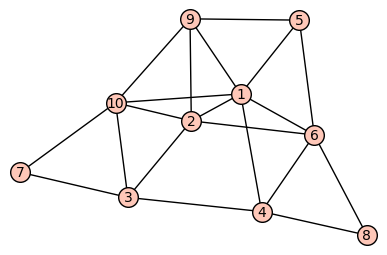

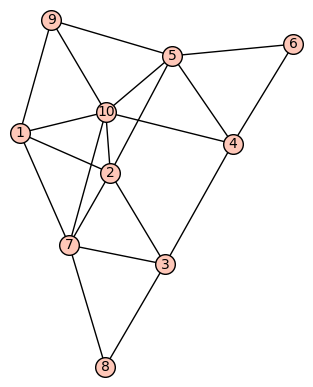

[10, 2, 3, 4, 9, 5, 8, 6, 1, 7]

In [327]:
G_1, G_2, phi = isomorphic_graphs(V, E)

G_1.show()
G_2.show()

phi

Now, for the prover first step we permute the first graph and send it to the verifier

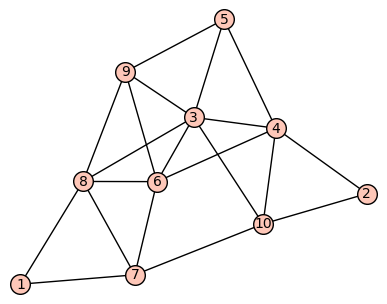

[9, 6, 7, 10, 4, 2, 8, 1, 5, 3]

In [328]:
G, sigma = random_permute(G_2)
G.show()

sigma

The verifier now asks to see an isomorphism to one of the two graphs selected at random

In [329]:
i = randint(1, 2)
i

2

Since the prover knows Phi, we can get a permutation in both cases

In [330]:
pi = sigma if i == 2 else sigma.left_action_product(phi)
pi

[9, 6, 7, 10, 4, 2, 8, 1, 5, 3]

Finally, the verifier simply checks that the pi(G_i) = G and we are done

In [331]:
G_i = G_1 if i == 1 else G_2
G_i.relabel(pi, inplace=False) == G

True

# Experiment
As before, we will encapsulate this as a procedure that can be run multiples times, furthermore we will also show a simulator that satisfies the zero knowledge property

In [332]:
# We use a class to plug different verifiers

honest = lambda G_1, G_2: HonestVerifier(G_1, G_2)

class HonestVerifier:
    def __init__(self, G_1, G_2):
        self.G_1 = G_1
        self.G_2 = G_2
    def challenge(self, G):
        self.G = G
        self.i = randint(1, 2)
        return self.i
    def verify(self, pi):
        G_i = self.G_1 if self.i == 1 else self.G_2
        return G_i.relabel(pi, inplace=False) == self.G
        
    
def procedure_honest_prover(G_1, G_2, phi, ver):
    G, sigma = random_permute(G_2)
    verifier = ver(G_1, G_2)
    i = verifier.challenge(G)
    pi = sigma if i == 2 else sigma.left_action_product(phi)
    return verifier.verify(pi)

Now we can set up an experiment to make sure that it always accepts

In [350]:
# Experiment Parameters
N = 2000


def experiment_honest(V, E, N):
    success_count = 0
    for i in range(0, N):
        G_1, G_2, phi = isomorphic_graphs(V, E)
        failure = False      
        success_count += procedure(G_1, G_2, phi, honest)
    return success_count / N

# An experiment where we have no isomorphism
def experiment_dishonest(V, E, N, procedure, verifier, works):
    success_count = 0
    for i in range(0, N):
        G_1, G_2 = random_graphs(V, E)
        failure = False      
        success_count += works(procedure(G_1, G_2, verifier))
    return success_count / N


We can see that this always succeeds with a honest verifier

In [348]:
experiment_honest(V, E, N)

1

Of course, if the two graphs are not isomorphic the prover will not be able to show an isomorphism of G to the other two, and as such it will have to give up at least once, here is a procedure that shows the best effort he can make (this will work 50% of the time on an honest verifier, a dishonest in this case can pick i = 2 and make the prover always fail)
See that the output probability hovers around 1/2

In [351]:
def procedure_dishonest_prover(G_1, G_2, ver):
    G, sigma = random_permute(G_2)
    verifier = ver(G_1, G_2)
    i = verifier.challenge(G)
    pi = sigma
    return verifier.verify(pi)

experiment_dishonest(V, E, N, procedure_dishonest_prover, honest, lambda x: x)

993/2000

Now we show a simulator that works for this problem (in particular, it outputs a transcript of the all the messages that the verifier receives before the verify step. This allows us to differentiate between a failed simulation and one that succeeds, while making sure that the distribution works accurately)

In [337]:
# We use ver to plug different verifiers
def simulator(G_1, G_2, ver):
    j = randint(1, 2)
    G_j = G_1 if j == 1 else G_2
    H, pi = random_permute(G_j)
    verifier = ver(G_1, G_2)
    i = verifier.challenge(H)
    if i not in [1, 2]:
        i = 2
    if i == j:
        return true, (G_1, G_2, H, pi)
    else:
        return false, None

You can now run the following cell for a single experiment, which will show how it succeeds around half of the time (with a honest verifier)

In [352]:
experiment_dishonest(V, E, N, simulator, honest, lambda x: x[0])

261/500